# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyxdf
import mne
import pandas as pd
import copy

from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import helpers
from helpers import *
import importlib
import scipy
from scipy import signal
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from operator import itemgetter
from skfeature.function.similarity_based import fisher_score
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score

In [76]:
importlib.reload(helpers)
from helpers import *

# Local functions

In [2]:
def feature_ranking(score,n_features=None):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    if n_features is None:
        n_features = len(score)

    idx = np.argsort(score, 0)
    return idx[::-1][:n_features]

# Fisher Score

### Load a subject

In [3]:
#subject_ID = np.random.randint(1,20)
EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(8,mode='eye_blink')
conditions = list(EEG_dict_corrected.keys())
MIPOST = [x for x in conditions if 'MIpost' in x][0]
MIPRE = [x for x in conditions if 'MIpre' in x][0]
EEG_dict = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)

Processing: Data/Group_Realistic_Arm/S08


Stream 2: Calculated effective sampling rate 5129.4601 Hz is different from specified rate 500.0000 Hz.
Stream 4: Calculated effective sampling rate 15151.2280 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1161033
    Range : 0 ... 1161032 =      0.000 ...   580.516 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   12.9s finished


Subject: sub-S08, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']


Stream 3: Calculated effective sampling rate 5945.2660 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 17577.2832 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1242042
    Range : 0 ... 1242041 =      0.000 ...   621.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   10.2s finished


Subject: sub-S08, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Reading Data/Group_Realistic_Arm/S08/ICA_data/sub-S08_MIpost_ses-S001_task-Default_run-001_eeg_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S08/ICA_data/sub-S08_MIpre_ses-S001_task-Default_run-001_eeg_ica ...
Now restoring ICA solution ...
Ready.


c:\Users\haiou\Documents\TNE\Python\helpers.py:308: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S08/ICA_data/sub-S08_MIpost_ses-S001_task-Default_run-001_eeg_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
c:\Users\haiou\Documents\TNE\Python\helpers.py:308: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S08/ICA_data/sub-S08_MIpre_ses-S001_task-Default_run-001_eeg_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')


Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from pr

Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 9 DPSS windows
(60, 13, 19)
(60, 247)
(60,)


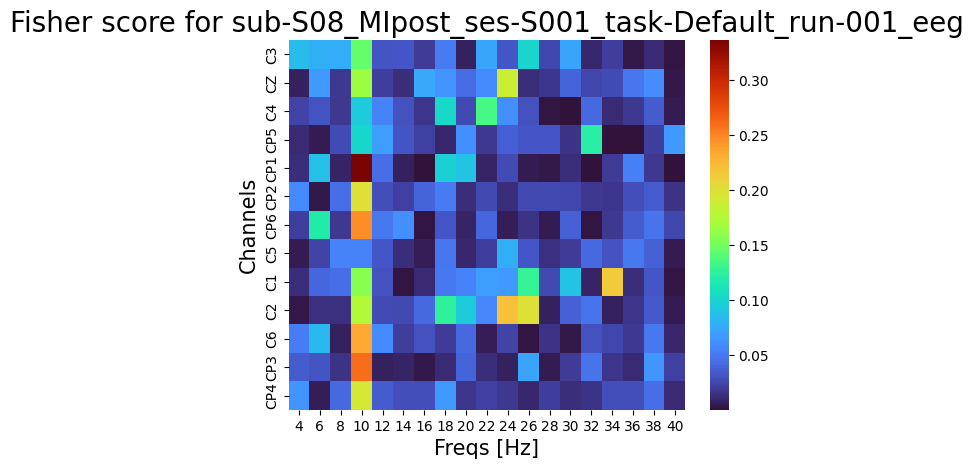

Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C3', 'CZ', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'C5', 'C2', 'C6', 'CP4']
    Rejecting  epoch based on EEG : ['C5', 'C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
11 bad epochs dropped
    Using multitaper spectrum estimation with 9 DPSS windows
(49, 13, 19)
(49, 247)
(49,)


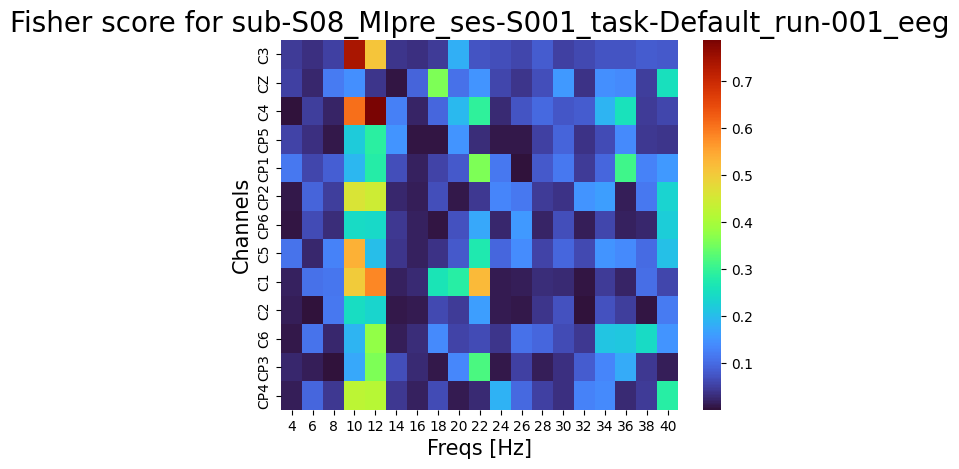

In [4]:
bandpower_dict,f_score_dict = fisher_analysis(EEG_dict_corrected_CAR,EVENTS_dict,mode='triple')

### First SVM trial 

In [5]:
cond = MIPOST
ranking = feature_ranking(f_score_dict[cond].reshape(f_score_dict[cond].shape[0]*f_score_dict[cond].shape[1]),20)
n_features = len(ranking)
print(ranking)

[ 79 212 117 193 181 167  98 182 231  29 174  22 155   3  47 163 178  71
 115  45]


In [166]:
power = bandpower_dict[cond]['power'].copy()
x = power.reshape(power.shape[0],power.shape[1]*power.shape[2])
X = x[:,ranking]
y = bandpower_dict[cond]['labels']

In [157]:
cv_inner = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
cv_outer = StratifiedKFold(n_splits=4,shuffle=True,random_state=42)

In [163]:
history = []
historyT = []
best_models = []
best_params = []
conf_matrix = []
test_set = []
pred_set = []
i = 1
cm_train = []
pointer = 1
for train_index, test_index in cv_outer.split(x, y):                          #3
     print('NestedCV: {} of outer fold {}'.format(pointer, cv_outer.get_n_splits()))
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

     print(x_train.shape)
     print(x_test.shape)
     print(y_train.shape)
     print(y_test.shape)

     # x_train = np.nan_to_num(x_train, nan=-99)
     # x_test = np.nan_to_num(x_test, nan=-99)

     svm_model = svm.SVC(random_state=0)
     model = RandomizedSearchCV(svm_model, param_distributions={'C': np.arange(1,101),'class_weight': ['balanced',{1: 10}],'kernel':['linear', 'rbf']},
                                   scoring='balanced_accuracy', cv=cv_inner, n_jobs=-1)     #4
     model.fit(x_train, y_train)
     
     pred_test = model.predict(x_test)
     pred_training = model.predict(x_train)
     
     
     ba_train = balanced_accuracy_score(y_train, pred_training)
     #     cmT = confusion_matrix(y_train, pred_training, labels=[1,2,3])#5
     ba_test = balanced_accuracy_score(y_test, pred_test)
     test_set.append(y_test)
     cm = confusion_matrix(y_test, pred_test)
     print(cm)
     #     df_cm = pd.DataFrame(cm)
     #     df_cm.to_csv('/kaggle/working' + "/" + "({i})confusion_matrix.csv")
     
     print("""
     # Best set of parameters: {}
     # Best BA             : {:.2f}

     # Training
          # BA: {:.3f}
     # Test
          # BA: {:.3f}
     # """.format(
          model.best_params_,
          model.best_score_,
          ba_train,
          ba_test,
          )
     )
     history.append(ba_test)
     historyT.append(ba_train)
     best_models.append(model.best_estimator_)
     best_params.append(model.best_params_)
     conf_matrix.append(cm)
     #     cm_train.append(cmT)
     pred_set.append(pred_test)
     pointer += 1

print('Overall test performance: {:.2f}'.format(np.mean(history)))

NestedCV: 1 of outer fold 4
(36, 20)
(13, 20)
(36,)
(13,)
[[7 1]
 [2 3]]

     # Best set of parameters: {'kernel': 'rbf', 'class_weight': 'balanced', 'C': 89}
     # Best BA             : 0.82

     # Training
          # BA: 1.000
     # Test
          # BA: 0.738
     # 
NestedCV: 2 of outer fold 4
(37, 20)
(12, 20)
(37,)
(12,)
[[7 1]
 [1 3]]

     # Best set of parameters: {'kernel': 'rbf', 'class_weight': 'balanced', 'C': 82}
     # Best BA             : 0.80

     # Training
          # BA: 1.000
     # Test
          # BA: 0.812
     # 
NestedCV: 3 of outer fold 4
(37, 20)
(12, 20)
(37,)
(12,)
[[7 0]
 [1 4]]

     # Best set of parameters: {'kernel': 'rbf', 'class_weight': 'balanced', 'C': 9}
     # Best BA             : 0.86

     # Training
          # BA: 1.000
     # Test
          # BA: 0.900
     # 
NestedCV: 4 of outer fold 4
(37, 20)
(12, 20)
(37,)
(12,)
[[5 2]
 [2 3]]

     # Best set of parameters: {'kernel': 'rbf', 'class_weight': {1: 10}, 'C': 20}
     # Best BA     

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [126]:
# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={1: 1})
wclf.fit(X, y)

SVC(class_weight={1: 1}, kernel='linear')

In [129]:
# Predict the labels of the test data
y_pred = wclf.predict(X)
# Calculate the accuracy of the classifier
conf_matrix = confusion_matrix(y, y_pred)

In [124]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [130]:
conf_matrix

array([[30,  0],
       [19,  0]], dtype=int64)